## Chapter 3: Constraint-satisfaction problems

Let's create a generic constraint-satisfaction problem solver that uses simple backtracking search.

A CSP problem is composed of:
* `variables`: a list of all variables in the problem.
* `domains`: a dict associating each variable to its domain (possible values).
* `constraints`: a dict associating each variable to the constraints that the variable is constrained by.

In [56]:
from abc import ABC, abstractmethod


class Constraint(ABC):
    # Base class for all constraints
    def __init__(self, variables: list):
        self.variables = variables  # the vars that the constraint constrains
        
    @abstractmethod
    def satisfied(self, assignment: dict) -> bool:
        # An assignment is a mapping of variables to their values
        pass
    
    def print_satisfied(self, assignment: dict, result: bool) -> None:
        print(str(assignment) + ' -> ' + self.__class__.__name__ + (' ✅' if result else ' ❌'))
    
    
class CSP(object):
    # Generic CSP solver
    def __init__(self, variables: list, domains: dict):
        self.variables = variables
        self.domains = domains
        self.constraints = {}
        for variable in self.variables:
            if variable not in self.domains:
                raise LookupError(f"Variable '{variable}' does not have a domain assigned to it")
            self.constraints[variable] = []
        self.count_states = 0  # to keep track of number of searched states
            
    def add_constraint(self, constraint) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError(f"Variable in constraint {variable} does not exist in CSP")
            self.constraints[variable].append(constraint)
            
    def consistent(self, variable, assignment: dict) -> bool:
        # Check if an assignment of variables to values is admissible for a
        # particular variable, by verifying all constraints of that variable
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    
    def backtracking_search(self, assignment={}):
        # Recursive depth-first search
        
        if len(assignment) == len(self.variables):
            # base case: all variables have been assigned
            return assignment
        
        unassigned = [v for v in self.variables if v not in assignment]
        first = unassigned[0]
        
        for value in self.domains[first]:  # try to assign each domain value
            self.count_states += 1
            temp_assignment = assignment.copy()  # shallow copy (changes only dict reference)
            temp_assignment[first] = value
            
            if self.consistent(first, temp_assignment):
                result = self.backtracking_search(temp_assignment)
                if result is not None:  # continue searching recursively
                    return result
                
        return None # no solution
    
    def run(self):
        return self.backtracking_search()
 

### Example: Simple scheduling CSP

_Toy example by CT, not in the book_

Below is a toy problem for scheduling a meeting between 3 colleagues, expressed as CSP.
The **variables** are potential meeting participants, the **domains** are available meeting times of each potential participant ('None' for no participation), and the **constraints** are the scheduling rules.

Note how the speed of the solution _and_ the solution itself vary by changing the order of variables and domain values! (e.g. try it with `variables[::-1]`)

In [100]:
# Let's subclass Constraints to create concrete implementations
# for this problem.

class SameTimeConstraint(Constraint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def satisfied(self, assignment: dict) -> bool:
        nonempties = [v for v in assignment.values() if v is not None]
        if len(nonempties) < 2:
            return True  # degenerate case, nothing to check
        result = len(set(nonempties)) == 1  # all variables have same time value
        self.print_satisfied(assignment, result)
        return result
    
    
class MinimumParticipantsConstraint(Constraint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_participants = len(self.variables) - 1  # n-1
        
    def satisfied(self, assignment: dict) -> bool:
        nonempties = [k for k, v in assignment.items() if v is not None]
        result = (len(self.variables) - len(assignment) + len(nonempties)) >= self.min_participants
        self.print_satisfied(assignment, result)
        return result
    
    
class WorkingHoursConstraint(Constraint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hours = {'min': 8, 'max': 17}
        
    def satisfied(self, assignment: dict) -> bool:
        for _, val in assignment.items():
            if val is None:
                # not participating to the meeting is neutral w/r/t this constraint
                continue
            else:
                result = val >= self.hours['min'] and val <= self.hours['max']
                self.print_satisfied(assignment, result)
                return result
        return True
    

class BigBrotherIsWatchingConstraint(Constraint):
    # BIG BROTHER IS WATCHING YOU!
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def satisfied(self, assignment: dict) -> bool:
        if 'BigBrother' not in assignment:
            return True  # wait for BigBrother to be assigned
        result = assignment['BigBrother'] is not None
        self.print_satisfied(assignment, result)
        return result
    

# Set up the problem
variables = ['Alice', 'Bob', 'Mallory', 'BigBrother']

# Values are available meeting hours ('None' means no participation)
domains = {
    'Alice': [None, 10, 12, 16, 20],
    'Bob': [None, 10, 12, 16],
    'Mallory': [None, 10, 16, 20],
    'BigBrother': [None, 12, 16]
}

constraints = [
    SameTimeConstraint(variables),
    WorkingHoursConstraint(variables),
    MinimumParticipantsConstraint(variables),
    BigBrotherIsWatchingConstraint(variables)
]

# Run the scheduler!
csp = CSP(variables, domains)
for con in constraints:
    csp.add_constraint(con)
    
solution = csp.run()
if solution is not None:
    print(f'\nSolution: {solution}')
    print(f'Searched states: {csp.count_states}')
else:
    print('\nNo solution found!')

{'Alice': None} -> MinimumParticipantsConstraint ✅
{'Alice': None, 'Bob': None} -> MinimumParticipantsConstraint ❌
{'Alice': None, 'Bob': 10} -> WorkingHoursConstraint ✅
{'Alice': None, 'Bob': 10} -> MinimumParticipantsConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': None} -> WorkingHoursConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': None} -> MinimumParticipantsConstraint ❌
{'Alice': None, 'Bob': 10, 'Mallory': 10} -> SameTimeConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': 10} -> WorkingHoursConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': 10} -> MinimumParticipantsConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': 10, 'BigBrother': None} -> SameTimeConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': 10, 'BigBrother': None} -> WorkingHoursConstraint ✅
{'Alice': None, 'Bob': 10, 'Mallory': 10, 'BigBrother': None} -> MinimumParticipantsConstraint ❌
{'Alice': None, 'Bob': 10, 'Mallory': 10, 'BigBrother': 12} -> SameTimeConstraint ❌
{'Alice': None, 'Bob': 10, 'Mallory': 10, 'BigB

### 3.5. SEND+MORE=MONEY: Pt. I

Note that this brute-force approach is actually very expensive!

We'll look at a solution using genetic algorithms in Chapter 5.

In [132]:
class SendMoreMoneyConstraint(Constraint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def satisfied(self, assignment) -> bool:
        # if there are duplicate values then it's not a solution
        if len(set(assignment.values())) < len(assignment):
            return False

        # if all variables have been assigned, check if it adds correctly
        if len(assignment) == len(self.variables):
            s: int = assignment["S"]
            e: int = assignment["E"]
            n: int = assignment["N"]
            d: int = assignment["D"]
            m: int = assignment["M"]
            o: int = assignment["O"]
            r: int = assignment["R"]
            y: int = assignment["Y"]
            send: int = s * 1000 + e * 100 + n * 10 + d
            more: int = m * 1000 + o * 100 + r * 10 + e
            money: int = m * 10000 + o * 1000 + n * 100 + e * 10 + y
            return send + more == money
        return True # no conflict


# Set up problem
letters = ["S", "E", "N", "D", "M", "O", "R", "Y"]
possible_digits = {}
for letter in letters:
    possible_digits[letter] = list(range(10))
# prevent that a number starts with 0
possible_digits["S"] = possible_digits["S"][1:]
possible_digits["M"] = possible_digits["M"][1:]

csp = CSP(letters, possible_digits)
csp.add_constraint(SendMoreMoneyConstraint(letters))

# Run solver
solution = csp.run()
if solution is not None:
    print(f'\nSolution: {solution}')
    print(f'Searched states: {csp.count_states}')
else:
    print('\nNo solution found!')
    


Solution: {'S': 9, 'E': 5, 'N': 6, 'D': 7, 'M': 1, 'O': 0, 'R': 8, 'Y': 2}
Searched states: 6085582


### 3.6 Circuit board layout

In this problem, the CSP solution is biased by the direction of the search across the grid, i.e. left-to-right and top-to-bottom. That means it will stop at the first acceptable snugly (or better: non-overlapping) solution it finds.

Could we add a heuristic to find the actual snugliest layout of all possible layouts? 

What if we run it multiple times, with different starting locations as seed (e.g. the 4 corners of the grid + the center), and then pick the solution that minimizes a cost function (e.g. the number of empty grid cells)?

In [240]:
from typing import NamedTuple


class Chip(object):
    # Implemented as regular object so that each instance
    # has unique hash (because needs to be dict key).
    # The two dimensions are interchangeable.
    def __init__(self, dim1: int, dim2: int):
        self.dim1 = dim1
        self.dim2 = dim2
        
    def __iter__(self):
        return iter([self.dim1, self.dim2])
    
    def __getitem__(self, item):
        return [self.dim1, self.dim2][item]
    
        
class GridLocation(NamedTuple):
    row: int
    column: int

        
def generate_grid(rows: int, columns: int):
    # initialize grid with zeros
    return [[0 for c in range(columns)] for r in range(rows)]


def generate_domain(chip, grid):
    # TODO: make more efficient using generators
    domain = []
    height = len(grid)
    width = len(grid[0])
    for row in range(height):
        for col in range(width):
            # if chip is not square, try both orientations
            # (default and rotated by 90 degrees)
            for dim in range(len(set(chip))):
                other_dim = dim - 1  # because 2D
                columns = range(col, col + chip[dim])
                rows = range(row, row + chip[other_dim])
                if col + chip[dim] <= width and row + chip[other_dim] <= height:
                    domain.append([GridLocation(r, c) for c in columns for r in rows])
    return domain


class CircuitBoardConstraint(Constraint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def satisfied(self, assignment) -> bool:
        # if there are any duplicates grid locations then there is an overlap
        all_locations = [locs for values in assignment.values() for locs in values]
        return len(set(all_locations)) == len(all_locations)


def plot_solution(solution) -> None:
    # Construct grid with chips from solution
    grid = generate_grid(9, 9)
    for i, chip_locs in enumerate(solution.values()):
        for loc in chip_locs:
            grid[loc.row][loc.column] = i + 1  # dummy categorical value

    # Plot grid with imshow
    cmap = plt.get_cmap('Set3')  # categorical colormap
    cmap.set_under('white')  # color for empty grid locations

    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    ax.set_title('Circuit board');
    ax.imshow(grid, vmin=1, cmap=cmap)
    ax.grid(which='minor', color='k', linewidth=0.5);

    # Labels for major ticks
    ax.set_xticks(range(9));
    ax.set_yticks(range(9));
    ax.set_xticklabels(range(1,10));
    ax.set_yticklabels(range(1,10));

    # Minor ticks
    ax.set_xticks([c+0.5 for c in range(9)], minor=True);
    ax.set_yticks([c+0.5 for c in range(9)], minor=True);
    

Now let's look at some examples. Each time you run the solver, it will shuffle the order of the chips in the list, so you can see how order biases the search.

There is also a bias of the dimension used first to search for a solution. In the implementation, rows are searched first, so the chips will tend to be placed along the vertical dimension.

Also note that there is no optimality criterion, just the non-overlapping constraint.


Solution found!
Searched states: 55


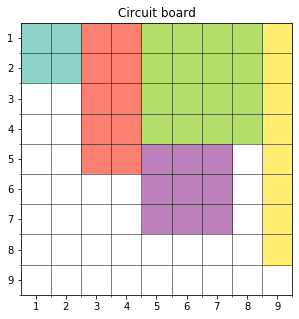

In [261]:
import random
import matplotlib.pyplot as plt
 
    
# Set up problem
grid = generate_grid(9, 9)
chips = [Chip(4,4), Chip(1,8), Chip(3,3), Chip(2,2), Chip(2,5)]  # dimensions of each chip
chips = random.sample(chips, len(chips))  # shuffle order of chips

locations = {}
for chip in chips:
    locations[chip] = generate_domain(chip, grid)
        
csp = CSP(chips, locations)
csp.add_constraint(CircuitBoardConstraint(chips))

# Run solver
solution = csp.run()
if solution is not None:
    print(f'\nSolution found!')
    print(f'Searched states: {csp.count_states}')
    plot_solution(solution)
else:
    print('\nNo solution found!')
    


### Exercise: Sudoku solver